# Empty Housing Rates in Spain: A Machine Learning Approach to Prediction and Interpretation

![Spain Banner](../img/España_2.jpg)

### **Author**: Guillermo Castillón Novo
---

## Objectives

- Build a **supervised regression model** capable of predicting the **percentage of empty housing units** across Spanish municipalities.
- Identify the most relevant **socio-demographic and economic drivers** behind housing vacancy rates using **model explainability techniques**.

*This notebook follows a complete end-to-end **machine learning workflow**, from data preprocessing and feature engineering to model training and interpretation.



## Potential Applications

- **Urban Planning**: Support local governments in targeting regions with higher housing vacancy for revitalization initiatives or infrastructure improvements.
- **Real Estate Investment**: Identify municipalities characteristics and potential to guide investment strategies.
- **Public Policy Design**: Help policymakers understand the socio-economic factors that drive housing vacancy to design more effective housing or migration policies.
- **Data-Driven Monitoring**: Build a scalable system to **track and predict housing market dynamics** across Spain over time.  

## Sources

The datasets used in this analysis were obtained from official Spanish public data portals.  
The sanitization and merging of these datasets into a unified CSV file is documented in the notebook [`first_look_and_merge.ipynb`](../notebooks/first_look_and_merge.ipynb).

- **Population and Housing Census (2021)**  
  Includes:  
  - Housing units by intensity of use (based on energy consumption)  
  - Population by sex and previous residence 10 years ago  
  - Population by sex and age (broad age groups)  
  [Link to source ↗](https://www.ine.es/dynt3/inebase/index.htm?padre=8952&capsel=8959) *(INE, 2021)*

- **Registered Unemployment by Municipality (2021)**  
  [Link to source ↗](https://datos.gob.es/es/catalogo/ea0021425-paro-registrado-por-municipios) *(Datos.gob.es)*

- **Geographical Information – Municipal Nomenclature**  
  [Link to source ↗](https://datos.gob.es/es/catalogo/e00125901-spaignnomenclatorgeograficomunicipiosentpob201503240000) *(Datos.gob.es)*


---

### Importing Libraries and Loading the Dataset

In [64]:
import numpy as np
import pandas as pd
import sys
import shap
sys.path.append("../utils/")
import gcn_tools as gc
from gcn_tools import *
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.feature_selection import SelectFromModel, RFE, RFECV, SequentialFeatureSelector
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, root_mean_squared_error
import joblib

In [2]:
df_final= pd.read_csv("../data_sample/DF_ALL_FEATURES.csv")

### **Data Preprocessing – Encoding, Cleaning and Train/Test Split**
- Dropping identifier columns such as municipality names and codes.
- Applying one-hot encoding to categorical features.
- Splitting the data into training and test sets for model evaluation.

In [3]:
df_final['Comunidad Autónoma_original'] = df_final['Comunidad Autónoma'] # Keeping the original categorical features (not the dummies) will be useful for visualizations later.
df_final['Provincia_original'] = df_final['Provincia']

In [ ]:
# One-hot encoding is applied to the categorical variables 'Comunidad Autónoma' and 'Provincia' for model compatibility.
# The target variable is defined as '%_casas_vacias'.

df_final= pd.get_dummies(df_final,columns=['Comunidad Autónoma', 'Provincia'],dtype=int) 
target='%_casas_vacias'

In [ ]:
X = df_final.drop(columns=['%_casas_vacias', 'ubicacion', 'codigo_ine']) #Target and identifier columns drop
y = df_final[target]

In [ ]:
# The dataset is split into training and test sets using an 80/20 ratio.

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(f"Tamaño de X_train: {X_train.shape}")
print(f"Tamaño de X_test: {X_test.shape}")
print(f"Tamaño de y_train: {y_train.shape}")
print(f"Tamaño de y_test: {y_test.shape}")

Tamaño de X_train: (2258, 113)
Tamaño de X_test: (565, 113)
Tamaño de y_train: (2258,)
Tamaño de y_test: (565,)


### **EDA: Exploratory Data Analysis**

- Target distribution (`%_casas_vacias`) ENG=(`%_empty_houses`)  
- Target Variation across different categorical groups
- Correlations and multicollinearity among numerical features, especially considering the presence of disaggregated variables (age groups and gender breakdowns)

#### Target Distribution Analysis:

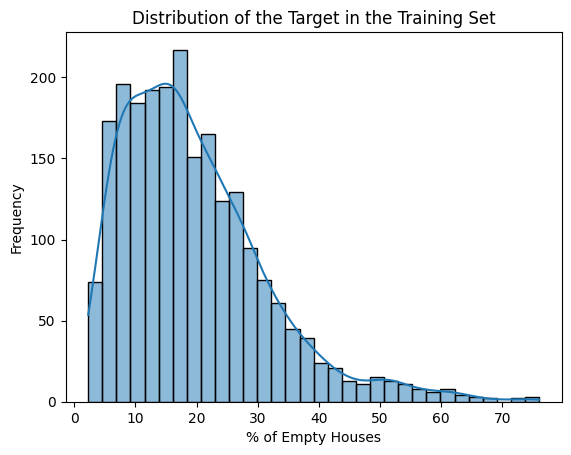

In [7]:
sns.histplot(y_train, kde=True)
plt.title("Distribution of the Target in the Training Set")
plt.xlabel("% of Empty Houses")
plt.ylabel("Frequency")
plt.show()

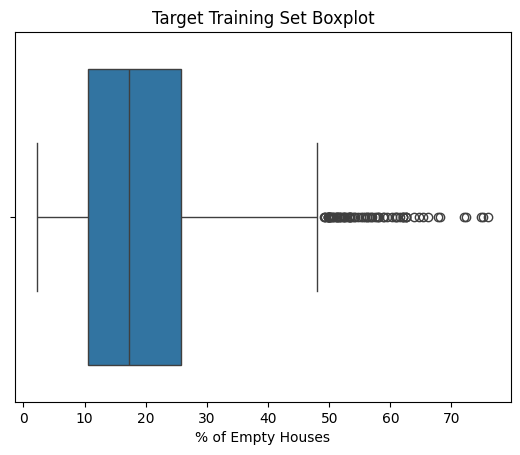

In [58]:
sns.boxplot(x=y_train)
plt.title("Target Training Set Boxplot")
plt.xlabel("% of Empty Houses")
plt.show()

In [9]:
y_train.describe()

count    2258.000000
mean       19.574191
std        11.873612
min         2.279570
25%        10.627861
50%        17.247061
75%        25.818683
max        76.021242
Name: %_casas_vacias, dtype: float64

#### Target Variation across different categorical groups:

In [10]:
def heatmap_mean_target_if_dummy_one(df, dummy_cols, target, title=None):
    """
    Displays a heatmap with the average value of the target variable
    only for rows where the dummy equals 1 (belongs to that group).

    Params:
    - df: pandas DataFrame containing the data.
    - dummy_cols: list of dummy column names (binary 0/1 features).
    - target: name of the target variable (string).
    - title: optional custom title for the heatmap.
    """
    mean_values = {col: df[df[col] == 1][target].mean() for col in dummy_cols}
    mean_df = pd.DataFrame.from_dict(mean_values, orient='index', columns=[f"Mean {target}"])
    mean_df = mean_df.sort_values(by=f"Mean {target}", ascending=False)

    plt.figure(figsize=(8, len(dummy_cols) * 0.4))
    sns.heatmap(mean_df, annot=True, cmap="YlOrRd", linewidths=0.5, fmt=".2f")
    plt.title(title)
    plt.show()


In [62]:
cat_feats=X_train.columns[40:]
train_set = pd.concat([X_train, y_train], axis=1)
comuni_cols= [col for col in cat_feats if ("Comunidad" in col) and col not in ["Comunidad Autónoma_original","Comunidad_Autónoma_Melilla"]]
provin_cols= [col for col in cat_feats if "Provincia" in col]

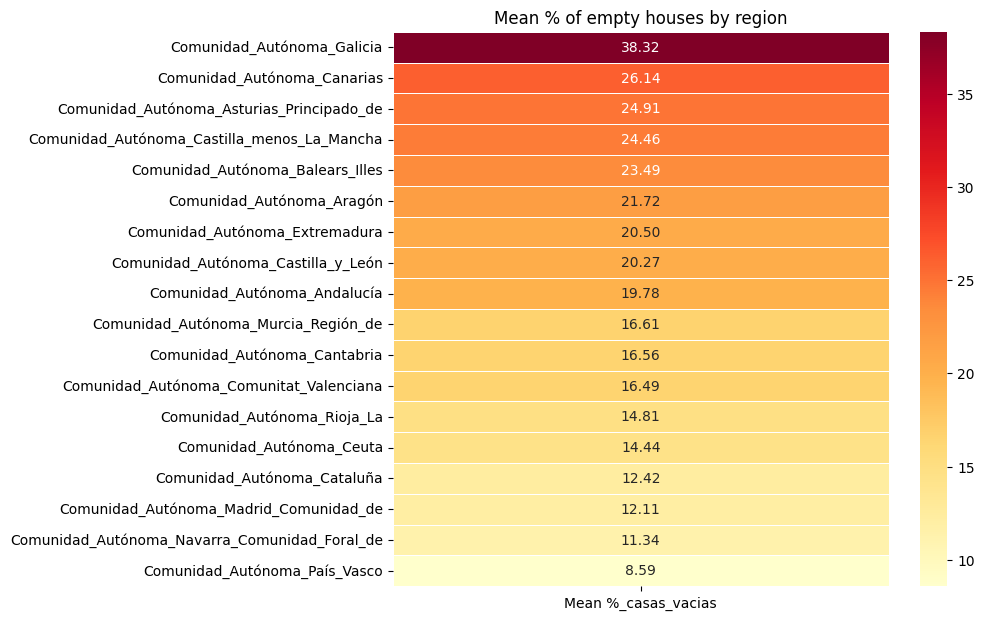

In [63]:
heatmap_mean_target_if_dummy_one(train_set, comuni_cols, target,"Mean % of empty houses by region")

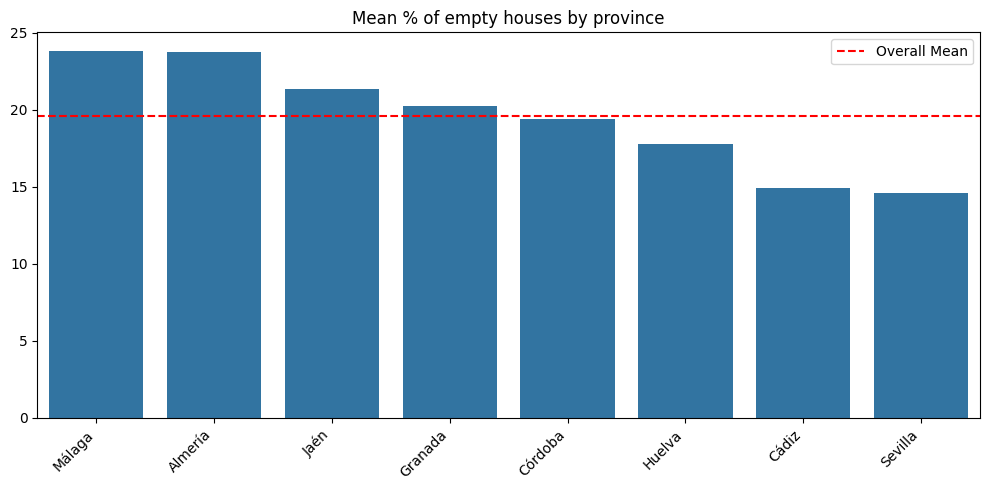

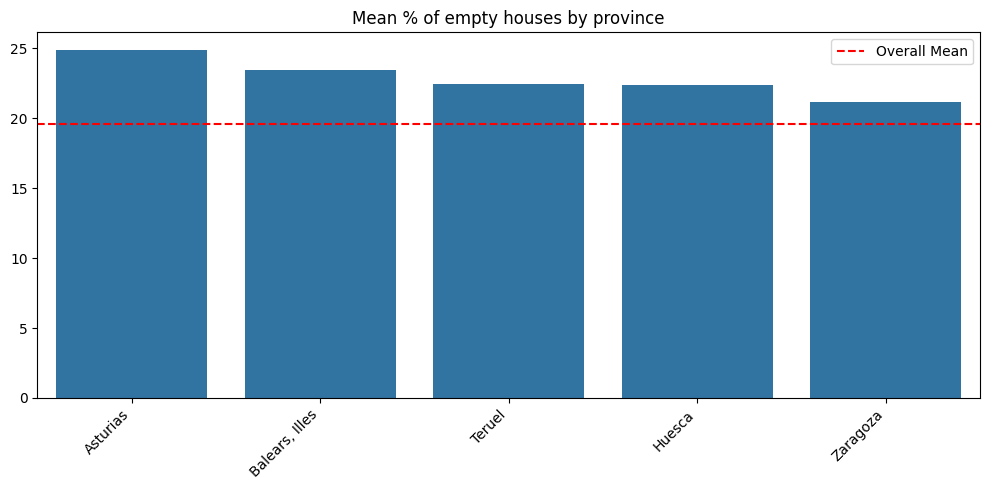

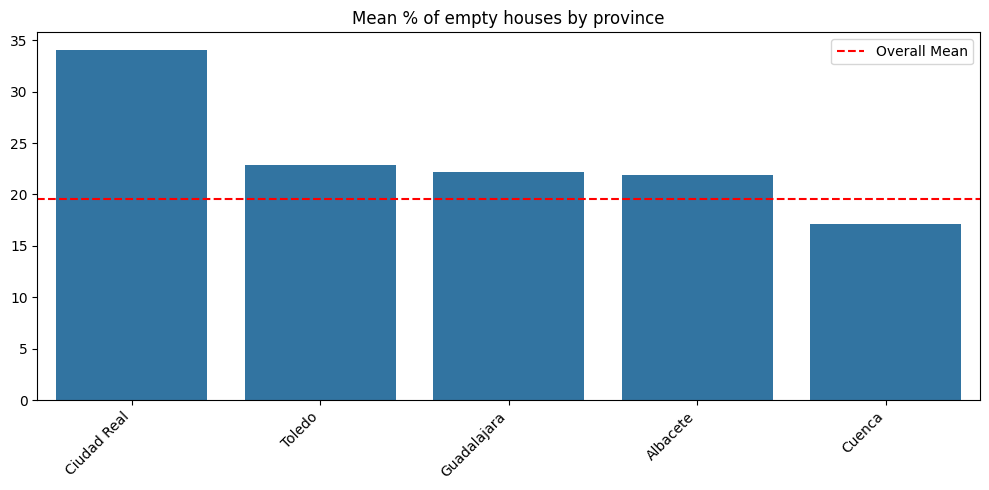

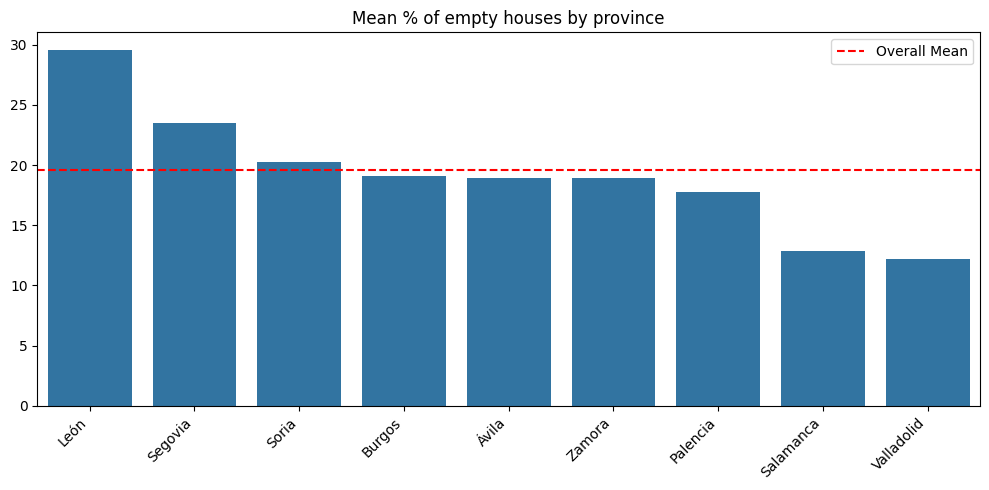

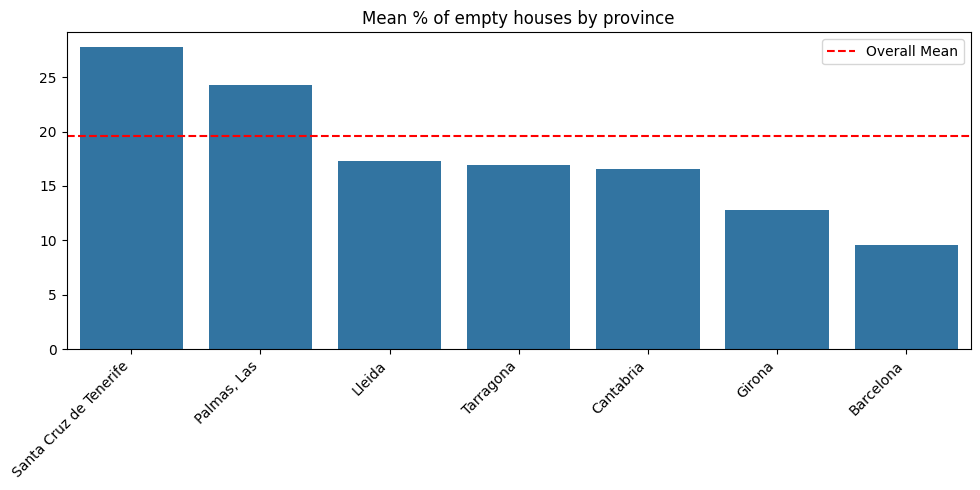

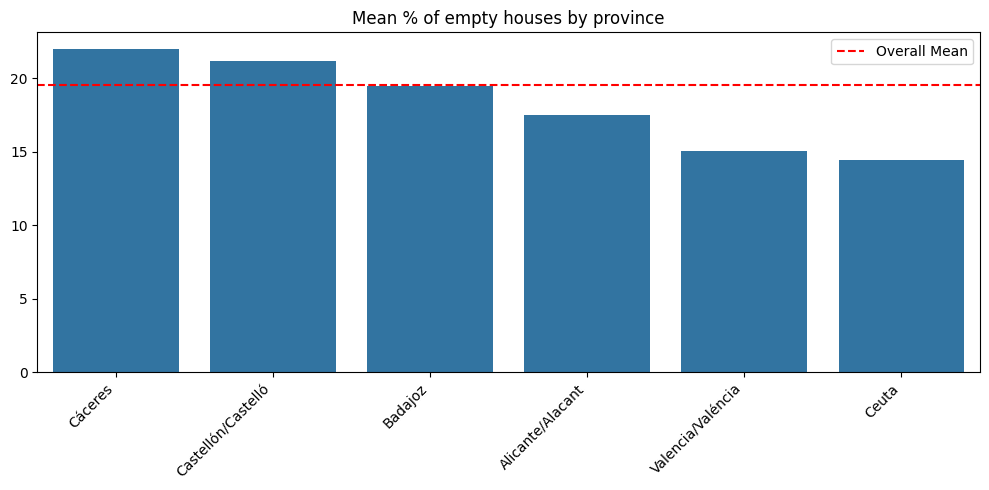

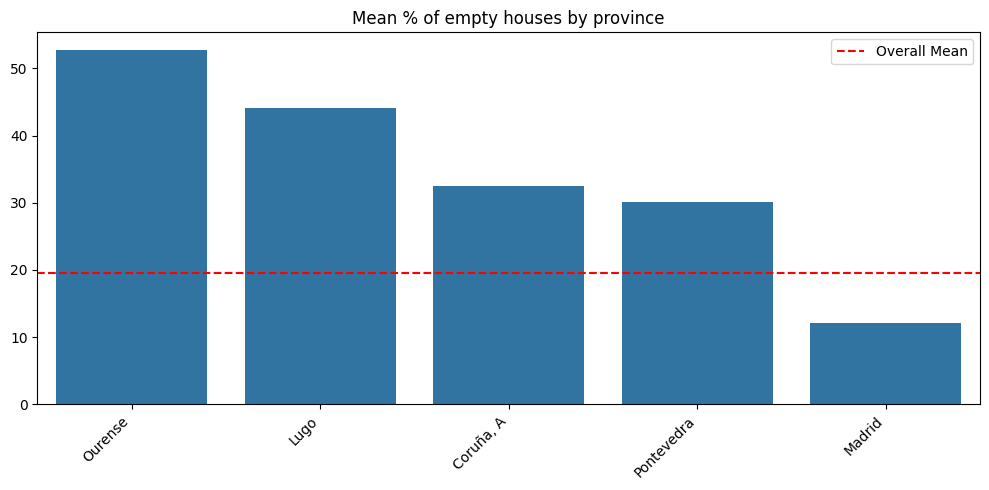

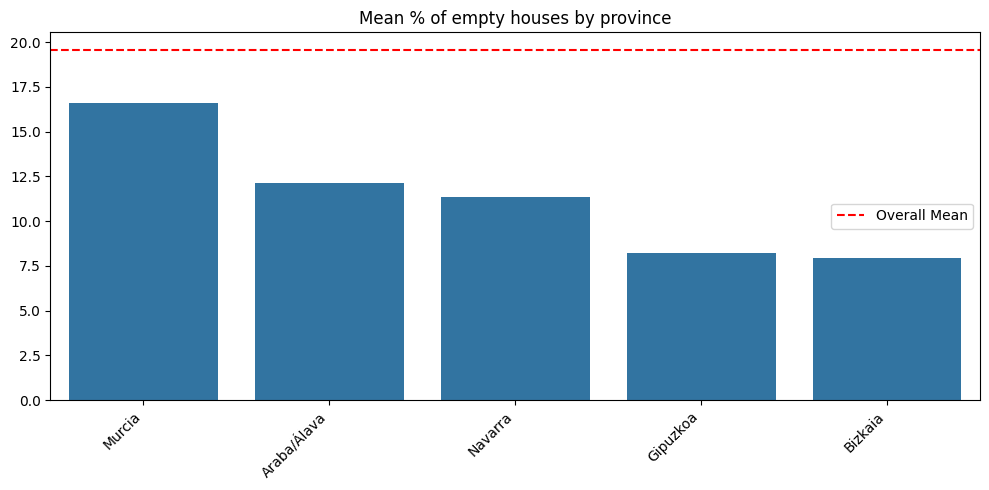

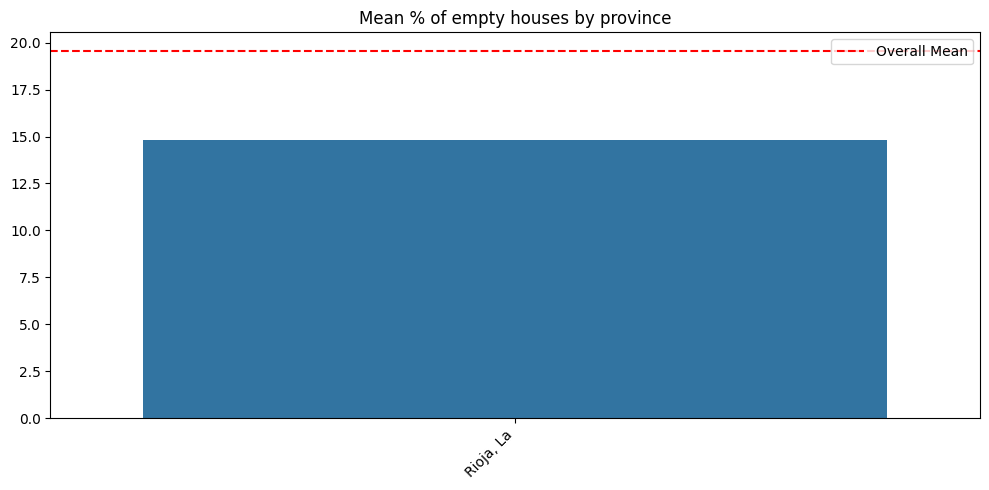

In [13]:
# Dictionary mapping each region (Comunidad Autónoma) to its corresponding provinces
comunidades_df = train_set[["Provincia_original", "Comunidad Autónoma_original"]].drop_duplicates()
comunidades_grouped = comunidades_df.groupby("Comunidad Autónoma_original")["Provincia_original"].unique()

comunidades = {com: list(provs) for com, provs in comunidades_grouped.items()}

# Definition of province groups for visualization (based on region)(max 9 provinces).
grupos = []
selec = []
for com, provs in comunidades.items():
    if len(provs) <= 4:
        selec.extend(provs)
        if len(selec) >= 5:
            grupos.append(selec[:9])
            selec = selec[9:]
    else:
        for i in range(0, len(provs), 9):
            grupos.append(provs[i:i+9])
if selec:
    grupos.append(selec)

# Generate visualizations of mean % of empty houses by province
for i, grupo in enumerate(grupos):
    datos = train_set[train_set["Provincia_original"].isin(grupo)]
    resumen = datos.groupby("Provincia_original")["%_casas_vacias"].mean().sort_values(ascending=False)
    
    plt.figure(figsize=(10, 5))
    sns.barplot(x=resumen.index.str.replace("_", " "), y=resumen.values)
    plt.axhline(train_set["%_casas_vacias"].mean(), color='red', linestyle='--', label="Overall Mean")
    plt.title(f"Mean % of empty houses by province")
    plt.xticks(rotation=45, ha='right')
    plt.legend()
    plt.xlabel("")
    plt.ylabel("")
    plt.tight_layout()
    plt.show()


In [14]:
#Object Columns Drop
X_train = X_train.drop(columns=['Comunidad Autónoma_original','Provincia_original'])
X_test = X_test.drop(columns=['Comunidad Autónoma_original','Provincia_original'])

#### Correlations and multicollinearity among numerical features, especially considering the presence of disaggregated variables (age groups and gender breakdowns)

In [15]:
# Dictionary grouping features with potential multicollinearity issues

posible_colinealidad_dict = {
    "Housing and Mobility": ['Viviendas totales', 'Mediana consumo anual', 'Viviendas con bajo consumo', 
                               'Viviendas de uso esporádico', 'prev_res_misma_vivienda', 'prev_res_mismo_municipio', 
                               'prev_res_misma_provincia', 'prev_res_misma_comunidad', 'prev_res_dif_comunidad', 
                               'prev_res_en_extranjero', 'prev_res_no_nacido'],
    
    "Demographics": ['Poblacion', 'Poblacion_-16', 'Poblacion_16-64', 'Poblacion_+65', 
                   'Hombres', 'Hombres_-16', 'Hombres_16-64', 'Hombres_+65', 
                   'Mujeres', 'Mujeres_-16', 'Mujeres_16-64', 'Mujeres_+65'],
    
    "Unemployment": ['total Paro Registrado', 'Paro hombre edad < 25', 'Paro hombre edad 25 -45 ', 
                      'Paro hombre edad >=45', 'Paro mujer edad < 25', 'Paro mujer edad 25 -45 ', 
                      'Paro mujer edad >=45', 'Paro Agricultura', 'Paro Industria', 
                      'Paro Construcción', 'Paro Servicios', 'Paro Sin empleo Anterior'],
    
    "Geography": ['SUPERFICIE', 'PERIMETRO', 'LONGITUD_ETRS89', 'LATITUD_ETRS89', 'ALTITUD']
}

In [ ]:
# Absolute correlation between target and numerical features.
correlaciones=train_set.iloc[:,:40].corrwith(y_train)
correlaciones=correlaciones.abs().sort_values(ascending=False)
correlaciones

LONGITUD_ETRS89                0.372081
ALTITUD                        0.204055
PERIMETRO                      0.201214
prev_res_misma_provincia       0.197341
Paro Industria                 0.189800
SUPERFICIE                     0.163653
Paro hombre edad < 25          0.151078
Paro Agricultura               0.146762
Paro mujer edad < 25           0.143387
Paro mujer edad >=45           0.136377
Paro Sin empleo Anterior       0.135365
prev_res_misma_vivienda        0.134821
Hombres_-16                    0.133664
Paro Construcción              0.133380
Poblacion_-16                  0.133269
Mujeres_-16                    0.132853
total Paro Registrado          0.132024
Paro mujer edad 25 -45         0.131754
prev_res_no_nacido             0.128634
Paro hombre edad >=45          0.125316
Paro Servicios                 0.123933
Viviendas de uso esporádico    0.123275
Paro hombre edad 25 -45        0.122417
prev_res_misma_comunidad       0.120616
Hombres                        0.119366


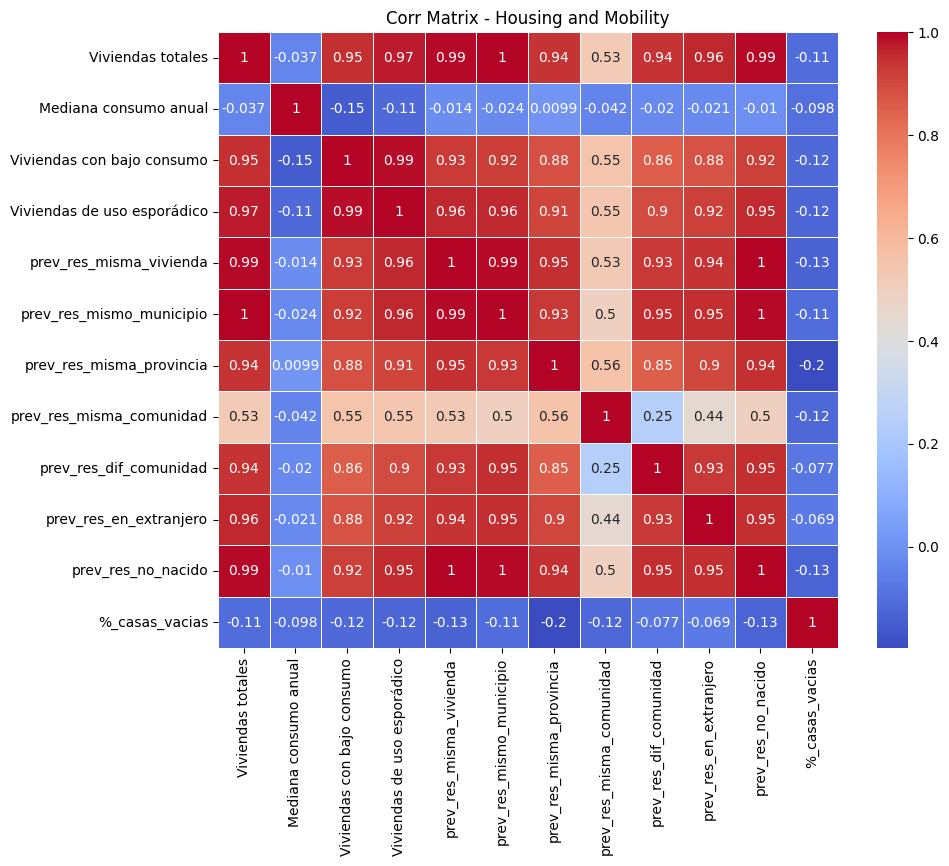

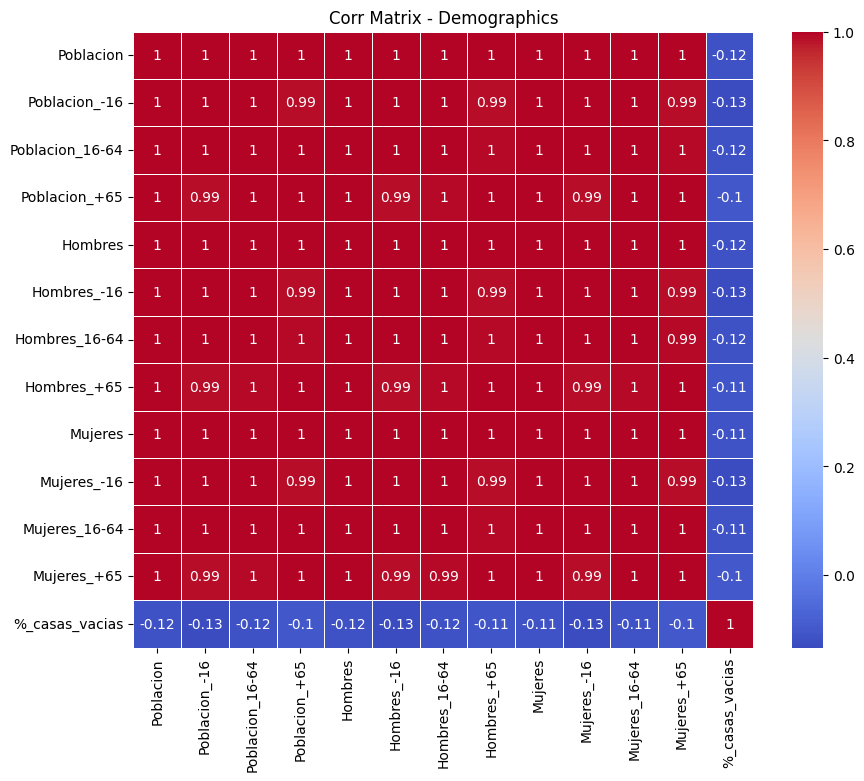

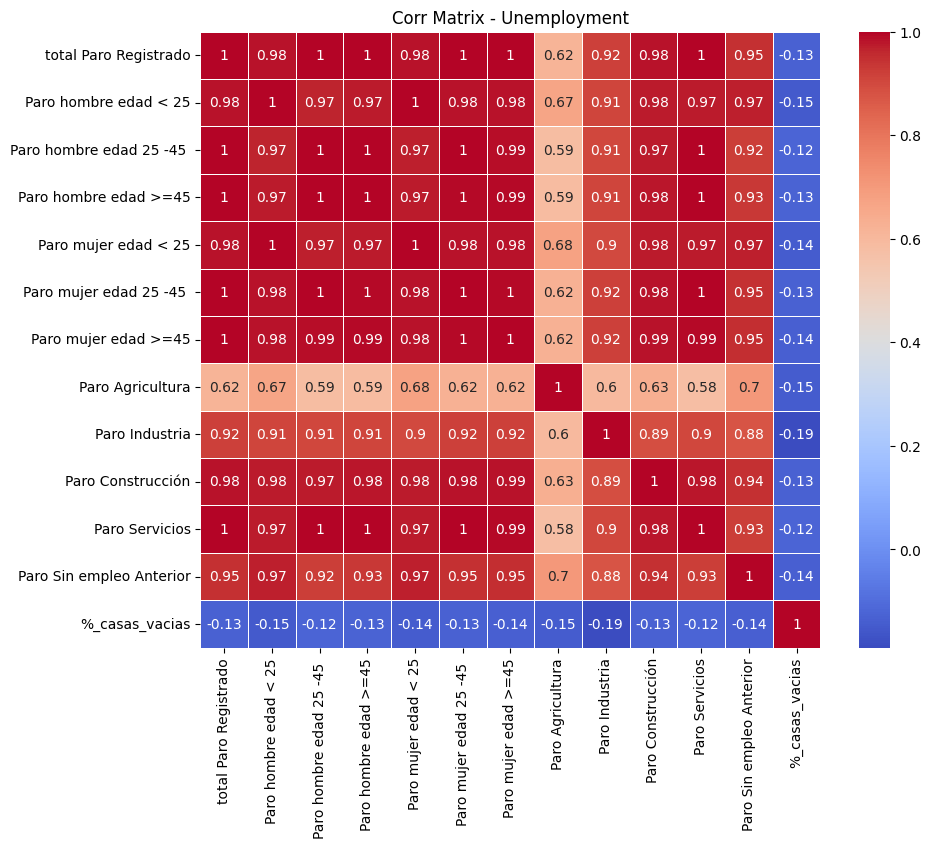

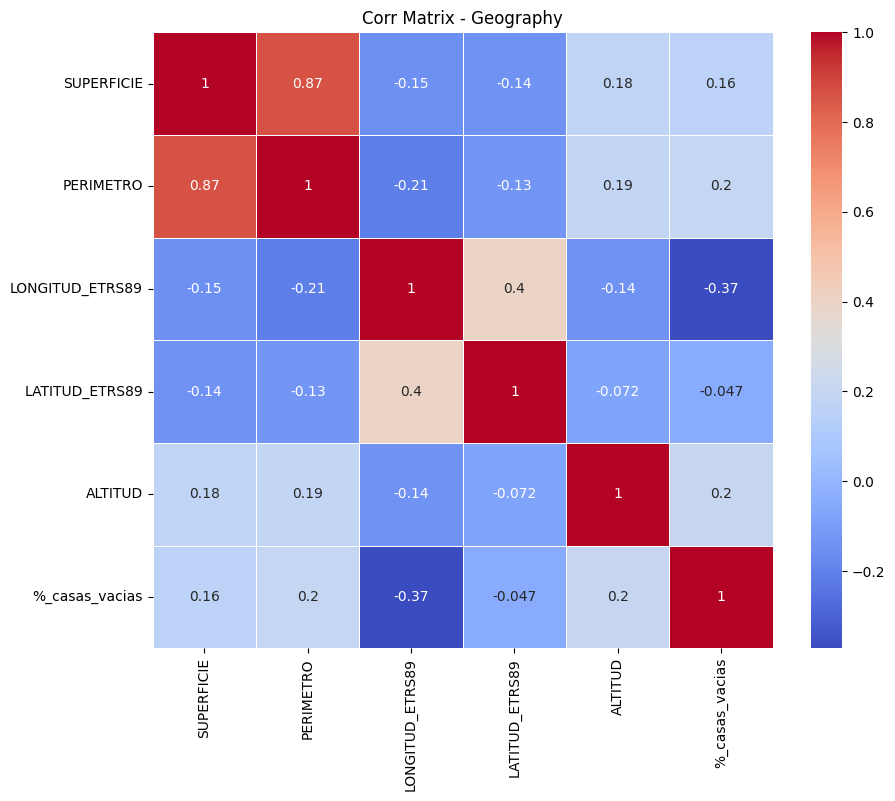

In [ ]:
# Collinearity analysis within groups of related variables.
# This analysis uses heatmaps to evaluate collinearity among features that are conceptually similar or represent disaggregated components of other variables within the same group

for nombre_grupo, lista_feats in posible_colinealidad_dict.items():
    columnas_a_usar = lista_feats + [target]
    df_subset = train_set[columnas_a_usar]

    corr_matrix = df_subset.corr()
    
    plt.figure(figsize=(10, 8))
    sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
    plt.title(f"Corr Matrix - {nombre_grupo}")
    plt.show()

In [ ]:
# For each group of potentially collinear features, pairwise correlations are evaluated.
# Variables with a correlation higher than the defined threshold are compared in terms of their correlation with the target.
# From each highly correlated pair, the variable with the weaker relationship to the target is removed.
# The remaining variables are stored in 'seleccion_anticolinealidad' and will be part of a list of diferente feature selections.

umbral_colinealidad = 0.95
seleccion_anticolinealidad = []

for nombre_grupo, lista_feats in posible_colinealidad_dict.items():
    print(f"\nEvaluating group: {nombre_grupo}")

    df_subset = train_set[lista_feats + [target]]
    corr_matrix = df_subset.corr().abs()
    variables_a_eliminar = []

    for var1 in lista_feats:
        for var2 in lista_feats:
            if var1 != var2 and corr_matrix.loc[var1, var2] > umbral_colinealidad:
                if abs(corr_matrix.loc[var1, target]) >= abs(corr_matrix.loc[var2, target]):
                    if var2 not in variables_a_eliminar:  
                        variables_a_eliminar.append(var2)
                else:
                    if var1 not in variables_a_eliminar:
                        variables_a_eliminar.append(var1)

    variables_finales = [var for var in lista_feats if var not in variables_a_eliminar]
    print(f"Removed variables: {variables_a_eliminar}")
    print(f"Kept variables: {variables_finales}")
    seleccion_anticolinealidad.extend(variables_finales)

print("\nTotal selected variables:")
print(seleccion_anticolinealidad)


Evaluating group: Housing and Mobility
Removed variables: ['Viviendas totales', 'prev_res_mismo_municipio', 'prev_res_en_extranjero', 'Viviendas con bajo consumo', 'Viviendas de uso esporádico', 'prev_res_no_nacido']
Kept variables: ['Mediana consumo anual', 'prev_res_misma_vivienda', 'prev_res_misma_provincia', 'prev_res_misma_comunidad', 'prev_res_dif_comunidad']

Evaluating group: Demographics
Removed variables: ['Poblacion', 'Poblacion_+65', 'Hombres_+65', 'Mujeres', 'Mujeres_16-64', 'Mujeres_+65', 'Poblacion_16-64', 'Hombres', 'Poblacion_-16', 'Hombres_16-64', 'Mujeres_-16']
Kept variables: ['Hombres_-16']

Evaluating group: Unemployment
Removed variables: ['total Paro Registrado', 'Paro hombre edad 25 -45 ', 'Paro hombre edad >=45', 'Paro mujer edad 25 -45 ', 'Paro Servicios', 'Paro mujer edad < 25', 'Paro mujer edad >=45', 'Paro Construcción', 'Paro Sin empleo Anterior']
Kept variables: ['Paro hombre edad < 25', 'Paro Agricultura', 'Paro Industria']

Evaluating group: Geography

### **Feature Selection**
- Manual selection: all_feats, num_feats, seleccion_anticolinealidad (selected in the previous section), seleccion_anticol_y_catfeats (selected + cat_features)    
- Model-based techniques: SelectFromModel, RFE, RFECV, and SFS using Random Forest

Subsets are stored in a dictionary for later model evaluation and comparison.

#### Manual Selection

In [19]:
all_feats=X_train.columns.to_list()
num_feats = [col for col in X_train.columns if X_train[col].nunique() > 2]
cat_feats = [col for col in X_train.columns if X_train[col].nunique() <= 2]
seleccion_anticol_y_catfeats= seleccion_anticolinealidad.copy()
seleccion_anticol_y_catfeats.extend(cat_feats)

In [ ]:
# Creation of the feature selection dictionary.

selecciones_features_dic={
    "all_feats": all_feats,   
    "num_feats": num_feats,                 
    "seleccion_anticolinealidad": seleccion_anticolinealidad,
    "seleccion_anticol_y_catfeats": seleccion_anticol_y_catfeats,
}

#### Model-based Techniques

In [ ]:
# Feature selection using SelectFromModel with a RandomForestRegressor
STOPP
rf_selector = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
rf_selector.fit(X_train, y_train)

selector = SelectFromModel(rf_selector, threshold="median")
selector.fit(X_train, y_train)
seleccion_modelo = X_train.columns[selector.get_support()].tolist()

selecciones_features_dic["seleccion_modelo"]= seleccion_modelo

'\n#Primero con el selectfrommodel entrenando un modelo de randomforest\nfrom sklearn.feature_selection import SelectFromModel\nfrom sklearn.ensemble import RandomForestRegressor\n\nrf_selector = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)\nrf_selector.fit(X_train, y_train)\n\nselector = SelectFromModel(rf_selector, threshold="median")\nselector.fit(X_train, y_train)\nseleccion_modelo = X_train.columns[selector.get_support()].tolist()\n\nprint(len(seleccion_modelo))\nprint(seleccion_modelo)\n'

In [ ]:
# Feature selection using RFE with Random Forest for multiple feature counts (20, 35, 50, 65, 80)

STOPP
rf_rfe = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
num_features_list = [20, 35, 50, 65, 80] 
selecciones_rfe_list = []

for num_features in num_features_list:
    rfe_selector = RFE(estimator=rf_rfe, n_features_to_select=num_features)
    rfe_selector.fit(X_train, y_train)
    seleccion_actual = X_train.columns[rfe_selector.ranking_ == 1].tolist()
    selecciones_rfe_list.append(seleccion_actual)

selecciones_features_dic["seleccion_rfe_20"] = selecciones_rfe_list[0]
selecciones_features_dic["seleccion_rfe_35"] = selecciones_rfe_list[1]
selecciones_features_dic["seleccion_rfe_50"] = selecciones_rfe_list[2]
selecciones_features_dic["seleccion_rfe_65"] = selecciones_rfe_list[3]
selecciones_features_dic["seleccion_rfe_80"] = selecciones_rfe_list[4]

'\n\n#Ahora con RFE y voy a probar varias cantidades quiero una seleccion de 20 otra de 35, de 50, de 65 y de 80\nfrom sklearn.feature_selection import RFE\n\nrf_rfe = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)\nnum_features_list = [20, 35, 50, 65, 80] \nselecciones_rfe_list = []\n\nfor num_features in num_features_list:\n    rfe_selector = RFE(estimator=rf_rfe, n_features_to_select=num_features)\n    rfe_selector.fit(X_train, y_train)\n    seleccion_actual = X_train.columns[rfe_selector.ranking_ == 1].tolist()\n    selecciones_rfe_list.append(seleccion_actual)\n\nselecciones_features_dic["seleccion_rfe_20"] = selecciones_rfe_list[0]\nselecciones_features_dic["seleccion_rfe_35"] = selecciones_rfe_list[1]\nselecciones_features_dic["seleccion_rfe_50"] = selecciones_rfe_list[2]\nselecciones_features_dic["seleccion_rfe_65"] = selecciones_rfe_list[3]\nselecciones_features_dic["seleccion_rfe_80"] = selecciones_rfe_list[4]\n\n'

In [ ]:
# Feature selection using RFECV with Random Forest to automatically determine the optimal number of features

STOPP
rf_RFECV = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
rfecv = RFECV(estimator=rf_RFECV, step=1, cv=5, n_jobs=-1)
rfecv.fit(X_train, y_train)

num_opt = rfecv.n_features_
features_rfecv = X_train.columns[rfecv.support_].tolist()

selecciones_features_dic["seleccion_rfecv"] = features_rfecv

'\n# VOY A UTILIZAR RFECV QUE SELECCIONA DE POR SI EL NUMERO OPTIMO DE FEATURES Y LUEGO HARÉ 3 SFS QUE SELECCIONEN FEATURES ALREDEDOR DE ESE NUMERO OPTIMO.\n\nfrom sklearn.feature_selection import RFECV\n\nrf_RFECV = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)\nrfecv = RFECV(estimator=rf_RFECV, step=1, cv=5, n_jobs=-1)\nrfecv.fit(X_train, y_train)\n\nnum_opt = rfecv.n_features_\nfeatures_rfecv = X_train.columns[rfecv.support_].tolist()\n\nselecciones_features_dic["seleccion_rfecv"] = features_rfecv\n'

In [ ]:
# Feature selection using SFS with Random Forest around the optimal number of features (±3)

STOPP
rf_sfs = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
num_features_list = [num_opt - 3, num_opt, num_opt + 3]

for num_features in num_features_list:
    sfs_selector = SequentialFeatureSelector(rf_sfs, n_features_to_select=num_features, cv=5, n_jobs=-1)
    sfs_selector.fit(X_train, y_train)
    print(len(sfs_selector.get_feature_names_out()))
    seleccion_actual = list(sfs_selector.get_feature_names_out())
    key_name = f"seleccion_sfs_{num_features}"
    selecciones_features_dic[key_name] = seleccion_actual

'\nfrom sklearn.feature_selection import SequentialFeatureSelector\n\nrf_sfs = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)\nnum_features_list = [num_opt - 3, num_opt, num_opt + 3]\n\nfor num_features in num_features_list:\n    sfs_selector = SequentialFeatureSelector(rf_sfs, n_features_to_select=num_features, cv=5, n_jobs=-1)\n    sfs_selector.fit(X_train, y_train)\n    print(len(sfs_selector.get_feature_names_out()))\n    seleccion_actual = list(sfs_selector.get_feature_names_out())\n    key_name = f"seleccion_sfs_{num_features}"\n    selecciones_features_dic[key_name] = seleccion_actual\n\n'

In [28]:
'''

#GUARDO EL DICCIONARIO CON JSON PARA NO TENER QUE REPETIR MÁS ESTA EJECUCIÓN.
import json

with open("../data_sample/selecciones_features_dic.json", "w") as feat_dic:
    json.dump(selecciones_features_dic, feat_dic)

'''

'\n\n#GUARDO EL DICCIONARIO CON JSON PARA NO TENER QUE REPETIR MÁS ESTA EJECUCIÓN.\nimport json\n\nwith open("../data_sample/selecciones_features_dic.json", "w") as feat_dic:\n    json.dump(selecciones_features_dic, feat_dic)\n\n'

In [21]:
import json

with open("../data_sample/selecciones_features_dic.json", "r") as feat_dic:
    selecciones_features_dic = json.load(feat_dic)

### **Model Comparison Setup**

Before evaluating model performance, the following steps are performed:

- Column renaming: Some models (e.g., XGBoost, LightGBM) don't support special characters in feature names. All column names are sanitized accordingly.

- Log transformation: Right-skewed numerical features are log-transformed to improve model learning.

- Model dictionaries:  
  - Models requiring feature scaling (e.g., Ridge, Lasso) are used within pipelines with `StandardScaler`.  
  - Tree-based models (e.g., Random Forest, CatBoost) are used directly.
- Cross Validation, Test Evaluation, Model Comparison  

Only interpretable models are selected to enable analysis of feature importance.


#### Column Renaming

In [22]:
# Column names sanitizing function applied to the features selection dictionary, X_train and X_test

def renombrar_problematicas(nombre):
    nombre = nombre.replace("<", "menor_que")
    nombre = nombre.replace(">=", "mayor_igual")
    nombre = nombre.replace("+", "mas")
    nombre = nombre.replace("-", "menos")
    nombre = nombre.replace("/", "_")
    nombre = nombre.replace(",", "")
    nombre = nombre.replace(" ", "_")
    nombre = nombre.replace("__", "_")
    return nombre

X_train.columns = [renombrar_problematicas(col) for col in X_train.columns]
X_test.columns = [renombrar_problematicas(col) for col in X_test.columns]

def limpiar_diccionario_features(diccionario_original):
    diccionario_limpio = {}
    for clave, lista in diccionario_original.items():
        nueva_lista = [renombrar_problematicas(var) for var in lista]
        diccionario_limpio[clave] = nueva_lista
    return diccionario_limpio

selecciones_features_dic = limpiar_diccionario_features(selecciones_features_dic)

#### Log transformation

array([[<Axes: title={'center': 'Viviendas_totales'}>,
        <Axes: title={'center': 'Mediana_consumo_anual'}>,
        <Axes: title={'center': 'Viviendas_con_bajo_consumo'}>,
        <Axes: title={'center': 'Viviendas_de_uso_esporádico'}>,
        <Axes: title={'center': 'prev_res_misma_vivienda'}>,
        <Axes: title={'center': 'prev_res_mismo_municipio'}>],
       [<Axes: title={'center': 'prev_res_misma_provincia'}>,
        <Axes: title={'center': 'prev_res_misma_comunidad'}>,
        <Axes: title={'center': 'prev_res_dif_comunidad'}>,
        <Axes: title={'center': 'prev_res_en_extranjero'}>,
        <Axes: title={'center': 'prev_res_no_nacido'}>,
        <Axes: title={'center': 'Poblacion'}>],
       [<Axes: title={'center': 'Poblacion_menos16'}>,
        <Axes: title={'center': 'Poblacion_16menos64'}>,
        <Axes: title={'center': 'Poblacion_mas65'}>,
        <Axes: title={'center': 'Hombres'}>,
        <Axes: title={'center': 'Hombres_menos16'}>,
        <Axes: title={

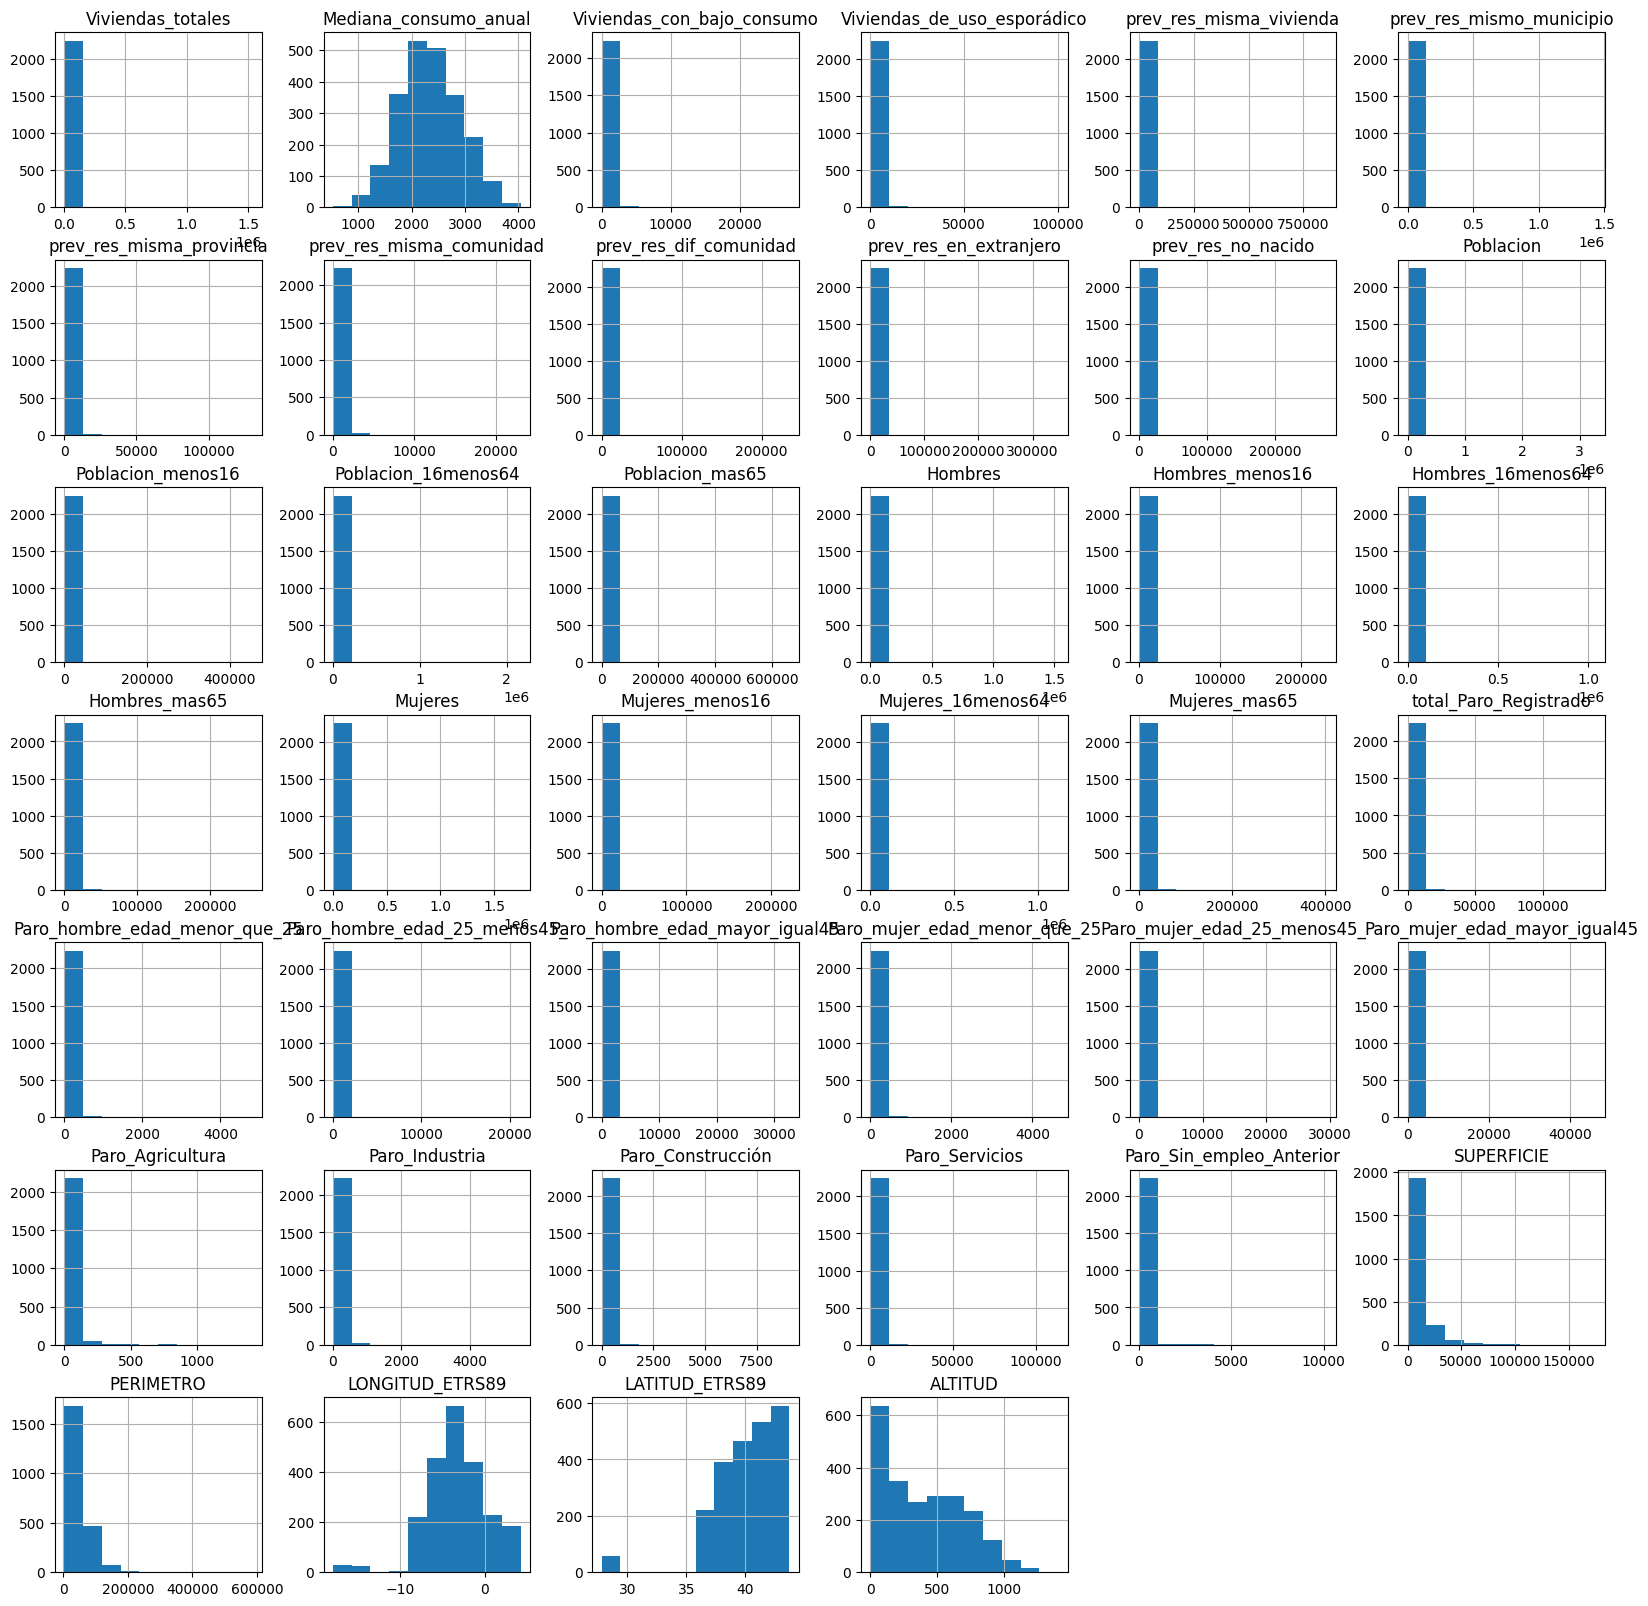

In [23]:
# Visual inspection of numerical feature distributions to assess the need for log transformation

num_feats= selecciones_features_dic["num_feats"]
X_train[num_feats].hist(figsize=(20,20))

In [24]:
# Log-transforming selected numerical features (excluding those that don't require transformation)

logaritmizar=[col for col in num_feats if col not in ['Mediana consumo anual', 'LONGITUD_ETRS89', 'LATITUD_ETRS89', 'ALTITUD']]
X_train_trans = X_train.copy()
X_test_trans = X_test.copy()

for col in logaritmizar:
    X_train_trans[col] = np.log1p(X_train_trans[col])
    X_test_trans[col] = np.log1p(X_test_trans[col])

#### Model dictionaries

In [25]:
# Model Dictionaries: Linear models are wrapped in pipelines with StandardScaler, non-linear models are used directly

modelos_lineales = {
    "LinearRegression": Pipeline([
        ("scaler", StandardScaler()),
        ("modelo", LinearRegression())
    ]),
    "Ridge": Pipeline([
        ("scaler", StandardScaler()),
        ("modelo", Ridge(random_state=42))
    ]),
    "Lasso": Pipeline([
        ("scaler", StandardScaler()),
        ("modelo", Lasso(random_state=42))
    ])
}

modelos_no_lineales = {
    "DecisionTree": DecisionTreeRegressor(random_state=42),
    "RandomForest": RandomForestRegressor(random_state=42, n_jobs=-1),
    "LightGBM": LGBMRegressor(random_state=42, n_jobs=-1),
    "XGBoost": XGBRegressor(random_state=42, n_jobs=-1, verbosity=0),
    "CatBoost": CatBoostRegressor(random_state=42, verbose=0)
}
modelos = {**modelos_lineales, **modelos_no_lineales}

#### Model Comparison

In [ ]:
# Loop through all models and feature selection strategies to evaluate performance.
# Linear models use log-transformed features with scaling (via pipeline), while non-linear models use original features.
# For each model-feature combination, cross-validation RMSE is computed, followed by model fitting and prediction on the test set.
# RMSE, R², and MAE are recorded to compare model performance across different feature selection methods. 
# Results were saved in a DataFrame and exported to avoid rerunning this computationally expensive step.

STOPP
resultados = []

for modelo_nombre, modelo in modelos.items():
    print(f"MODELO --- {modelo_nombre}")
    
    if modelo_nombre in modelos_lineales:
        X_train_base = X_train_trans
        X_test_base = X_test_trans
    else:
        X_train_base = X_train
        X_test_base = X_test

    for metodo_seleccion, lista_features in selecciones_features_dic.items():
        
        X_train_sel = X_train_base[lista_features]
        X_test_sel = X_test_base[lista_features]
        scores = cross_val_score(modelo, X_train_sel, y_train, cv=5, scoring="neg_root_mean_squared_error", n_jobs=-1)
        modelo.fit(X_train_sel, y_train)
        y_pred = modelo.predict(X_test_sel)

        rmse_test = np.sqrt(mean_squared_error(y_test, y_pred))
        r2_test = r2_score(y_test, y_pred)
        mae_test = mean_absolute_error(y_test, y_pred)

        print(f"Feature Selection: {metodo_seleccion}")
        print(f"RMSE (CV): {-scores.mean():.2f}")
        print(f"RMSE (TEST): {rmse_test:.2f}")

        resultados.append({
            "Modelo": modelo_nombre,
            "Feature Selection": metodo_seleccion,
            "Número de Features": len(lista_features),
            "RMSE (CV)": -scores.mean(),
            "RMSE (TEST)": rmse_test,
            "R2 (TEST)": r2_test,
            "MAE (TEST)": mae_test})

df_resultados = pd.DataFrame(resultados).sort_values(by="RMSE (TEST)")

'\n\nfrom sklearn.model_selection import cross_val_score\nfrom sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score\nimport numpy as np\nimport pandas as pd\n\nresultados = []\n\nfor modelo_nombre, modelo in modelos.items():\n    print(f"MODELO --- {modelo_nombre}")\n    \n    if modelo_nombre in modelos_lineales:\n        X_train_base = X_train_trans\n        X_test_base = X_test_trans\n    else:\n        X_train_base = X_train\n        X_test_base = X_test\n\n    for metodo_seleccion, lista_features in selecciones_features_dic.items():\n        \n        X_train_sel = X_train_base[lista_features]\n        X_test_sel = X_test_base[lista_features]\n        scores = cross_val_score(modelo, X_train_sel, y_train, cv=5, scoring="neg_root_mean_squared_error", n_jobs=-1)\n        modelo.fit(X_train_sel, y_train)\n        y_pred = modelo.predict(X_test_sel)\n\n        rmse_test = np.sqrt(mean_squared_error(y_test, y_pred))\n        r2_test = r2_score(y_test, y_pred)\n     

In [26]:
# Load previously saved model evaluation results to avoid recomputation and display the top entries

df_resultados=pd.read_csv("../data_sample/df_resultados_modelos.csv")

pd.set_option('display.float_format', '{:.3f}'.format) # Prevent numbers from being displayed in scientific notation
df_resultados.head(40)

,Modelo,Feature Selection,Número de Features,RMSE (CV),RMSE (TEST),R2 (TEST),MAE (TEST)
0,Ridge,seleccion_rfe_80,80,4.762,4.680,0.865,3.494
1,LinearRegression,seleccion_rfe_80,80,4.749,4.684,0.865,3.521
2,Ridge,all_feats,111,4.759,4.714,0.863,3.504
3,LinearRegression,seleccion_rfe_65,65,4.733,4.725,0.863,3.559
4,Ridge,seleccion_rfe_65,65,4.754,4.732,0.862,3.550
5,LinearRegression,seleccion_modelo,56,4.768,4.736,0.862,3.590
6,Ridge,seleccion_modelo,56,4.792,4.751,0.861,3.589
7,LinearRegression,seleccion_rfe_50,50,4.791,4.818,0.857,3.652
8,Ridge,seleccion_rfe_50,50,4.817,4.837,0.856,3.655
9,LinearRegression,seleccion_rfe_35,35,4.856,4.840,0.856,3.683


### **Model Optimization: Grid Search**

Following the initial model evaluation, a hyperparameter optimization process is conducted using Grid Search*.

- The selection of models and feature subsets for optimization is manual, based on the performance observed in the previous comparison (`df_resultados`).
- The process includes two linear models (Linear Regression and Ridge) and two non-linear models (CatBoost and LightGBM), chosen for their balance between performance and interpretability.
- For models requiring standardized inputs, a pipeline with StandardScaler is applied.
- Each model-feature selection combination is trained using the best hyperparameters found, and evaluated on the test set using the following metrics:
  - Root Mean Squared Error (RMSE)
  - Coefficient of Determination (R²)
  - Mean Absolute Error (MAE)


- **Chosen models**: `Ridge`, `LinearRegression`, `CatBoost`, `LightGBM`
- **Selected feature subsets**: `seleccion_rfe_80`, `seleccion_rfecv`

In [ ]:
# Definition of models and their corresponding hyperparameter grids for grid search optimization
# Linear models are wrapped in pipelines with scaling, non-linear models are used directly


modelos_param_grid = {
    "Ridge": {
        "modelo": Pipeline([
            ("scaler", StandardScaler()),
            ("modelo", Ridge())]),
        "param_grid": {
            "modelo__alpha": [0.01, 0.1, 1, 10, 100]  
        }
    },
    "LinearRegression": {
        "modelo": Pipeline([
            ("scaler", StandardScaler()),
            ("modelo", LinearRegression())]),
        "param_grid": {}  
    },
    "CatBoost": {
        "modelo": CatBoostRegressor(verbose=0, random_state=42),
        "param_grid": {
            "iterations": [100, 300, 1000],  
            "depth": [4, 6, 8],
            "learning_rate": [0.01, 0.05, 0.1]
        }
    },
    "LightGBM": {
        "modelo": LGBMRegressor(random_state=42),
        "param_grid": {
            "n_estimators": [100, 300, 1000],  
            "num_leaves": [15, 31, 50],        
            "learning_rate": [0.01, 0.05, 0.1]
        }}} 
    


In [ ]:
# GridSearchCV loop for manually selected models and feature subsets to optimize hyperparameters.
# The best parameters and performance metrics (RMSE, R², MAE) are recorded for each model-selection combination.
# Results are saved in a DataFrame (df_resultados_gs) for comparison and analysis.


modelos_grid_search = ["Ridge", "LinearRegression", "CatBoost", "LightGBM"]
selecciones_grid_search = ["seleccion_rfe_80", "seleccion_rfecv"]

resultados_gs = []

for modelo_nombre in modelos_grid_search:
    for seleccion in selecciones_grid_search:
        print(f"GridSearchCV --- modelo: {modelo_nombre} seleccion: {seleccion}")

        modelo = modelos_param_grid[modelo_nombre]["modelo"]
        param_grid = modelos_param_grid[modelo_nombre]["param_grid"]

        if modelo_nombre in ["LinearRegression", "Ridge"]:
            X_train_sel = X_train_trans[selecciones_features_dic[seleccion]]
            X_test_sel = X_test_trans[selecciones_features_dic[seleccion]]
        else:
            X_train_sel = X_train[selecciones_features_dic[seleccion]]
            X_test_sel = X_test[selecciones_features_dic[seleccion]]

        gs = GridSearchCV(modelo, param_grid, scoring="neg_root_mean_squared_error", cv=5, n_jobs=-1)
        gs.fit(X_train_sel, y_train)
        y_pred = gs.predict(X_test_sel)

        resultados_gs.append({
            "Modelo": modelo_nombre,
            "Feature Selection": seleccion,
            "Número de Features": len(selecciones_features_dic[seleccion]),
            "Mejores Params": gs.best_params_,
            "RMSE (CV)": round(-gs.best_score_, 3),
            "RMSE (TEST)": round(np.sqrt(mean_squared_error(y_test, y_pred)), 3),
            "R2 (TEST)": round(r2_score(y_test, y_pred), 3),
            "MAE (TEST)": round(mean_absolute_error(y_test, y_pred), 3)
        })

df_resultados_gs = pd.DataFrame(resultados_gs).sort_values(by="RMSE (TEST)").reset_index(drop=True)


'\n\nfrom sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score\nfrom sklearn.model_selection import GridSearchCV\nmodelos_grid_search = ["Ridge", "LinearRegression", "CatBoost", "LightGBM"]\nselecciones_grid_search = ["seleccion_rfe_80", "seleccion_rfecv"]\n\nresultados_gs = []\n\nfor modelo_nombre in modelos_grid_search:\n    for seleccion in selecciones_grid_search:\n        print(f"GridSearchCV --- modelo: {modelo_nombre} seleccion: {seleccion}")\n\n        modelo = modelos_param_grid[modelo_nombre]["modelo"]\n        param_grid = modelos_param_grid[modelo_nombre]["param_grid"]\n\n        if modelo_nombre in ["LinearRegression", "Ridge"]:\n            X_train_sel = X_train_trans[selecciones_features_dic[seleccion]]\n            X_test_sel = X_test_trans[selecciones_features_dic[seleccion]]\n        else:\n            X_train_sel = X_train[selecciones_features_dic[seleccion]]\n            X_test_sel = X_test[selecciones_features_dic[seleccion]]\n\n        gs = Gri

In [46]:
'''
df_resultados_gs.to_csv("../data_sample/df_resultados_gridsearch.csv", index=False)
df_resultados_gs'
'''

'\ndf_resultados_gs.to_csv("../data_sample/df_resultados_gridsearch.csv", index=False)\ndf_resultados_gs\'\n'

In [32]:
df_resultados_gs= pd.read_csv("../data_sample/df_resultados_gridsearch.csv")
df_resultados_gs

,Modelo,Feature Selection,Número de Features,Mejores Params,RMSE (CV),RMSE (TEST),R2 (TEST),MAE (TEST)
0,Ridge,seleccion_rfe_80,80,{'modelo__alpha': 0.01},4.755,4.665,0.866,3.488
1,LinearRegression,seleccion_rfe_80,80,{},4.749,4.684,0.865,3.521
2,CatBoost,seleccion_rfecv,12,"{'depth': 6, 'iterations': 1000, 'learning_rat...",5.339,5.106,0.840,3.754
3,CatBoost,seleccion_rfe_80,80,"{'depth': 6, 'iterations': 1000, 'learning_rat...",5.373,5.226,0.832,3.872
4,LightGBM,seleccion_rfe_80,80,"{'learning_rate': 0.05, 'n_estimators': 1000, ...",5.327,5.303,0.827,3.961
5,LightGBM,seleccion_rfecv,12,"{'learning_rate': 0.1, 'n_estimators': 300, 'n...",5.355,5.321,0.826,3.934
6,Ridge,seleccion_rfecv,12,{'modelo__alpha': 0.01},5.488,5.372,0.822,4.144
7,LinearRegression,seleccion_rfecv,12,{},5.490,5.379,0.822,4.150


### **Final Model Evaluation and Interpretability**

This section presents the final evaluation of the best models: Ridge Regression and CatBoost, selected based on test performance and interpretability.

- Ridge Regression: Evaluated through predictive metrics and a scatter plot. Coefficients are used to study feature importance. Issue: interpretability may be affected by collinearity.

- CatBoost: Evaluated through predictive metrics and a scatter plot. Analyzed using built-in feature importance and SHAP values, which provide both magnitude and direction of each feature's impact.  

*A custom function is used to revert transformed feature names to their original form to enhance clarity in the interpretation of feature importance.

In [34]:
# Custom function used to revert transformed feature names to their original form
def revertir_nombres(nombre):
    nombre = nombre.replace("menor que", "<")
    nombre = nombre.replace("mayor igual", ">=")
    nombre = nombre.replace("mas", "+")
    nombre = nombre.replace("menos", "-")
    return nombre

#### RIDGE OPT MODEL:

In [ ]:
# Ridge regression model with optimized alpha and log-transformed features.
# Coefficients are extracted to study the importance and direction of influence of each selected variable.

features_ridge = selecciones_features_dic["seleccion_rfe_80"]
X_train_ridge = X_train_trans[features_ridge]
X_test_ridge = X_test_trans[features_ridge]

ridge_opt = Pipeline([
    ("scaler", StandardScaler()),
    ("modelo", Ridge(alpha=0.01, random_state=42))
])
ridge_opt.fit(X_train_ridge, y_train)

coeficientes = ridge_opt.named_steps["modelo"].coef_
importancia_df = pd.DataFrame({
    "Variable": features_ridge,
    "Importancia": coeficientes
})

In [66]:
# Saving the optimized Ridge regression model and the list of selected features used for training

joblib.dump(ridge_opt, "../models/modelo_ridge_opt.z", compress=5)
joblib.dump(features_ridge, "../models/features_ridge.pkl")


['../models/features_ridge.pkl']

RMSE: 4.665
R²: 0.866
MAE: 3.488


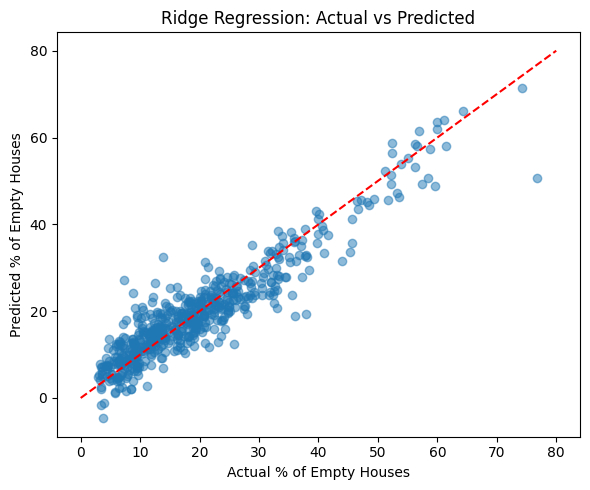

In [ ]:
# Evaluation of the optimized Ridge model on the test set using RMSE, R², and MAE.
# Visual representation of predictive accuracy through a scatter plot of actual vs. predicted values.

y_pred_ridge = ridge_opt.predict(X_test_ridge)
rmse_ridge = root_mean_squared_error(y_test, y_pred_ridge)
r2_ridge = r2_score(y_test, y_pred_ridge)
mae_ridge = mean_absolute_error(y_test, y_pred_ridge)

print(f"RMSE: {round(rmse_ridge,3)}")
print(f"R²: {round(r2_ridge,3)}")
print(f"MAE: {round(mae_ridge,3)}")

# Scatter plot: Real vs Predicted
plt.figure(figsize=(6, 5))
plt.scatter(y_test, y_pred_ridge, alpha=0.5)
plt.plot([0,80], [0,80], color='red', linestyle='--')
plt.xlabel("Actual % of Empty Houses")
plt.ylabel("Predicted % of Empty Houses")
plt.title("Ridge Regression: Actual vs Predicted")
plt.tight_layout()
plt.show()

In [ ]:
# Classification of Ridge regression coefficients as positive or negative, and calculation of their absolute values.
# features sorted by importance, and original variable names restored for clearer interpretation.

importancia_df["Signo"] = np.where(importancia_df["Importancia"] >= 0, "Positive", "Negative")
importancia_df["Importancia_abs"] = importancia_df["Importancia"].abs()
importancia_df = importancia_df.sort_values(by="Importancia_abs", ascending=False)
importancia_df["Variable"] = importancia_df["Variable"].apply(revertir_nombres)

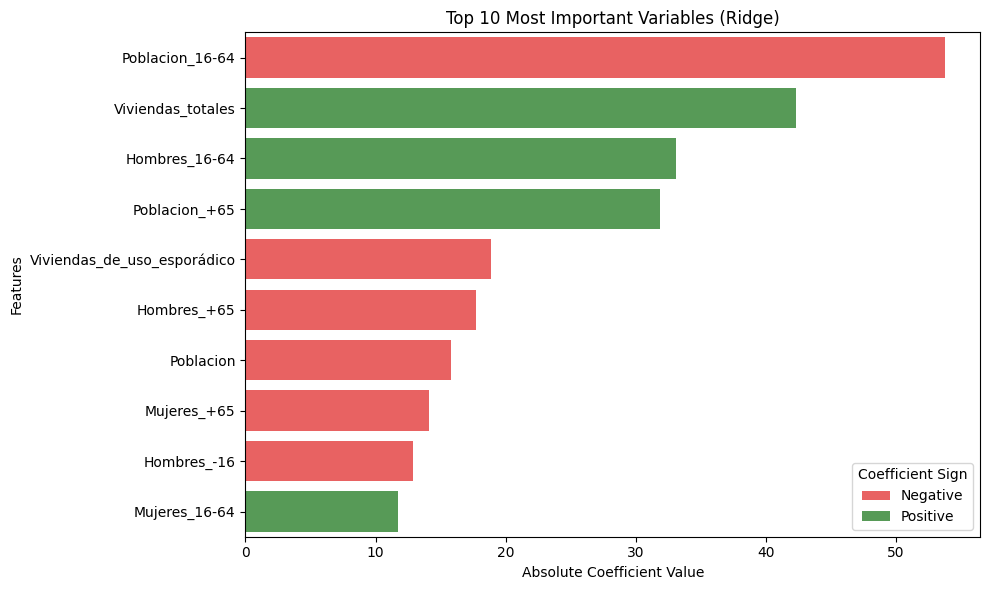

In [ ]:
# Visualization of the top 10 Ridge coefficients with sign indication.

plt.figure(figsize=(10, 6))
sns.barplot(
    data=importancia_df.head(10),
    x="Importancia_abs",
    y="Variable",
    hue="Signo",
    alpha= 0.7,
    palette={"Positive": "green", "Negative": "red"}
)
plt.title("Top 10 Most Important Variables (Ridge)")
plt.xlabel("Absolute Coefficient Value")
plt.ylabel("Features")
plt.legend(title="Coefficient Sign")
plt.tight_layout()
plt.show()

#### CATBOOST OPT MODEL:

In [47]:
df_resultados_gs.iloc[2]["Mejores Params"]

"{'depth': 6, 'iterations': 1000, 'learning_rate': 0.1}"

In [ ]:
# CatBoost regressor trained using the optimal hyperparameters and the optimal feature subset selected via RFECV.

mejores_params_catboost = {
    'depth': 6,
    'iterations': 1000,
    'learning_rate': 0.1,
    'random_state': 42,
    'verbose': 0
}

features_catboost = selecciones_features_dic["seleccion_rfecv"]
X_train_cat = X_train[features_catboost]
X_test_cat = X_test[features_catboost]

modelo_catboost = CatBoostRegressor(**mejores_params_catboost)
modelo_catboost.fit(X_train_cat, y_train)

In [ ]:
# Save the optimized CatBoost model and the list of selected features used for training

joblib.dump(modelo_catboost, "../models/modelo_catboost_opt.z", compress=5)
joblib.dump(features_catboost, "../models/features_catboost.pkl")

['../models/features_catboost.pkl']

RMSE: 5.106
R²: 0.84
MAE: 3.754


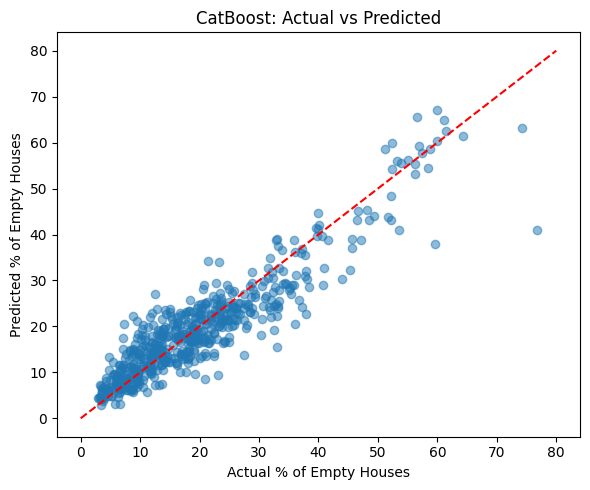

In [ ]:
# Evaluation of the optimized CatBoost model on the test set using RMSE, R², and MAE.
# Visual representation of predictive accuracy through a scatter plot of actual vs. predicted values.

y_pred_cat = modelo_catboost.predict(X_test_cat)
rmse_cat = root_mean_squared_error(y_test, y_pred_cat)
r2_cat = r2_score(y_test, y_pred_cat)
mae_cat = mean_absolute_error(y_test, y_pred_cat)

print(f"RMSE: {round(rmse_cat, 3)}")
print(f"R²: {round(r2_cat, 3)}")
print(f"MAE: {round(mae_cat, 3)}")

# Scatter plot: Real vs Predicted
plt.figure(figsize=(6, 5))
plt.scatter(y_test, y_pred_cat, alpha=0.5)
plt.plot([0, 80], [0, 80], color='red', linestyle='--')
plt.xlabel("Actual % of Empty Houses")
plt.ylabel("Predicted % of Empty Houses")
plt.title("CatBoost: Actual vs Predicted")
plt.tight_layout()
plt.show()

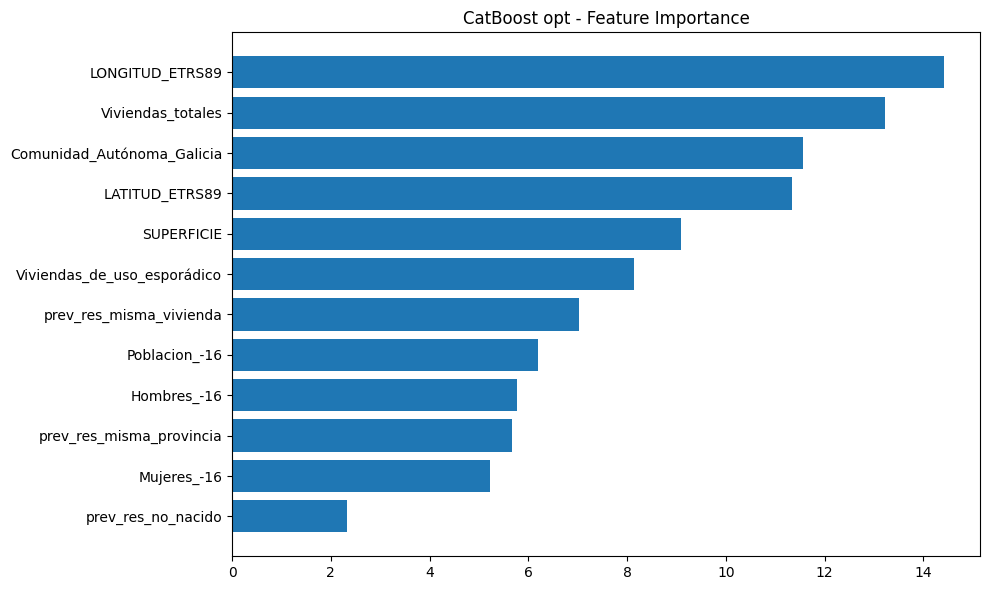

In [ ]:
# Feature importance scores are extracted from the optimized CatBoost model and visualized as a horizontal bar chart.
# Original variable names are restored to improve interpretability.

importancias = modelo_catboost.get_feature_importance(type="FeatureImportance")
df_importancias_cat = pd.DataFrame({
    "Variable": features_catboost,
    "Importancia": importancias
}).sort_values(by="Importancia")
df_importancias_cat['Variable'] = df_importancias_cat['Variable'].apply(revertir_nombres)


plt.figure(figsize=(10, 6))
plt.barh(df_importancias_cat["Variable"], df_importancias_cat["Importancia"])
plt.title("CatBoost opt - Feature Importance")
plt.tight_layout()
plt.show()

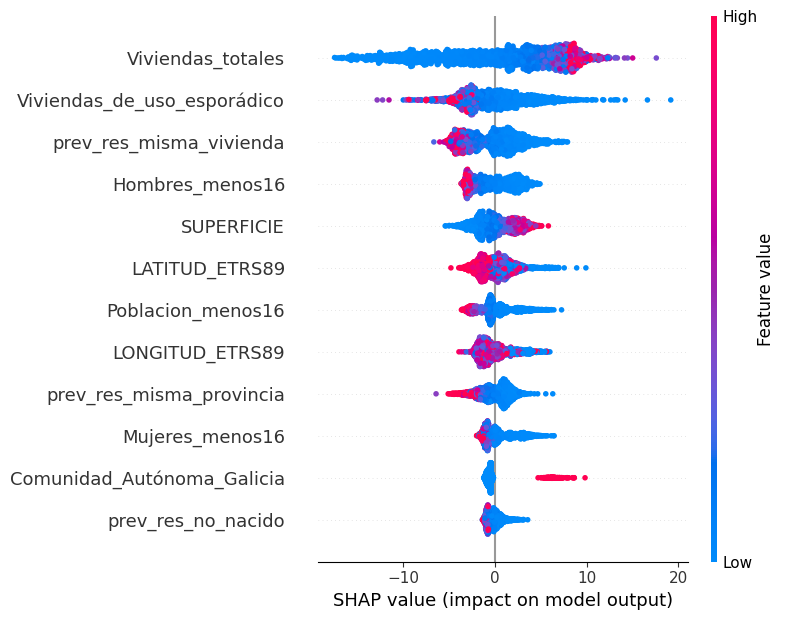

In [57]:
# SHAP values are computed to interpret the CatBoost model. 
# The summary plot shows both the magnitude and direction of each feature's impact on the predicted percentage of empty houses,
# indicating whether higher or lower values of a given variable contribute to an increase or decrease in the model's output.
import warnings
warnings.filterwarnings("ignore", message=".*IProgress not found.*")

explainer = shap.Explainer(modelo_catboost)
shap_values = explainer(X_train_cat)

plt.figure(figsize=(12, 8))
shap.summary_plot(shap_values, X_train_cat, show=True, plot_type="dot")